In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from dotenv import dotenv_values
from dotenv import load_dotenv
import sql_functions as sf
from sql_functions import get_sql_config, get_data, get_dataframe, get_engine

### 1. Star ratings


#### 1.1 Overview of star rating distribution 

In [3]:
#### create a df of business in PA from DB
schema = 'hh_analytics_23_3'
restaurants = sf.get_dataframe('SELECT * FROM hh_analytics_23_3.yelp_business_pa') 

In [4]:
# Group by stars 
ratings = restaurants.groupby(by='stars').count()
ratings = ratings.reset_index()
ratings = ratings[['stars', 'business_id']]

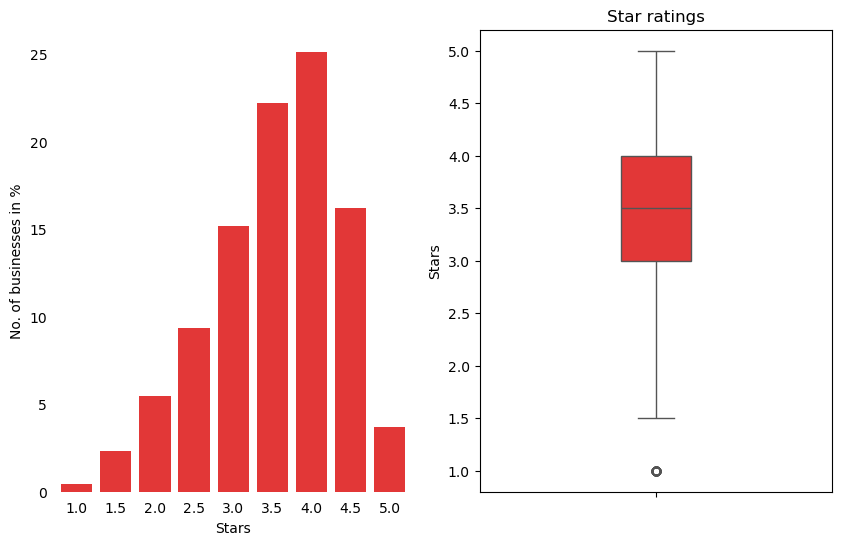

In [5]:
# Plot star rating distribution

fig, ax = plt.subplots(1, 2, figsize=(10, 6))
# fig.suptitle('Customer ratings', fontsize=16)
sns.barplot(ax = ax[0], x=ratings['stars'], y=ratings['business_id']*100/ratings['business_id'].sum(), color='#FF1A1A')
ax[0].set(xlabel='Stars', ylabel='No. of businesses in %')
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].tick_params(left = False)
ax[0].tick_params(bottom = False)
sns.boxplot(ax = ax[1], y=restaurants['stars'], width=0.2, color='#FF1A1A')
ax[1].set(ylabel='Stars')
ax[1].set_title('Star ratings');

#### 1.2 Co relation between attributes and star rating

### 2. Sentiment analysis of reviews of 3.5 biz 
We filtered all the business in PA with 3.5 stars rating as our target group, then we combined with review table, after we did sentiment analysis of it. 
We got 281,695 reviews in total. 

In [ ]:
# read the file of sentiment analysis of all the 3.5 biz in Pa
sentiment_target = pd.read_csv('data/sentiment_target.csv')
sentiment_target.shape

In [ ]:
sentiment_target

#### 2.1 Sentiment distribution

We visualized a distribution plot to see the stats of the positive, neutral, and negative reviews. 


Around 175,000 postive reviews, and more than 600,000 negative reviews.
Even the businesses in the range of 3.5, in total, the positive reviews are still 2 times more than the negative ones.
Have potential to improve

<Axes: xlabel='result', ylabel='count'>

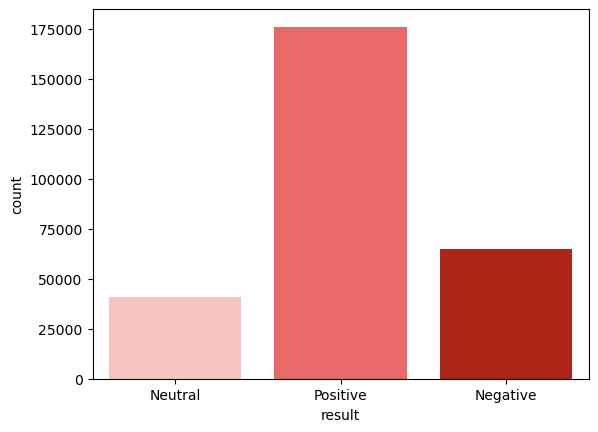

In [10]:
color = ["#ffbaba", "#ff5252", "#C41200"]
sns.countplot(x='result', data=sentiment_target, palette=color)

#### 2.2 Co relations between star rating and sentiment analysis result

In [7]:
# read review_all csv in dataframe to correlate stars with sentiment 
review_all = pd.read_csv('data/review_all.csv')
# correlation matrix between these variables
corr_columns=['stars','positive', 'neutral','negative' ]
corr_mtrx=review_all[corr_columns].corr()
corr_mtrx

stars  positive   neutral  negative
stars     1.000000  0.433734 -0.005024  -0.46449
positive  0.433734  1.000000       NaN       NaN
neutral  -0.005024       NaN  1.000000       NaN
negative -0.464490       NaN       NaN   1.00000

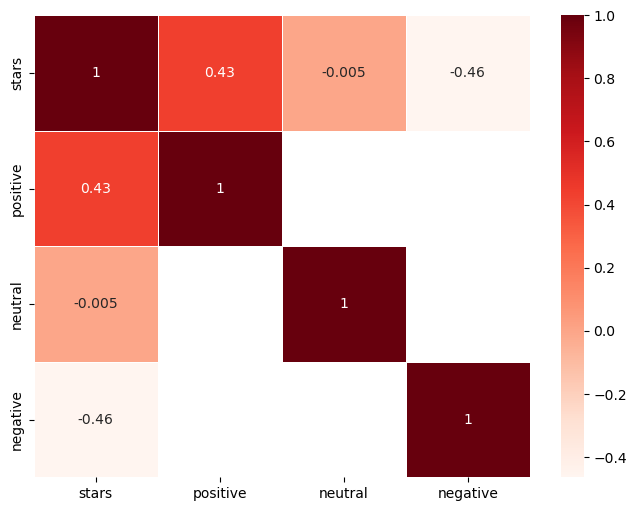

In [8]:
# Draw the heatmap of correlation table with the combination of reds.
plt.figure(figsize = (8,6))
ax = sns.heatmap(corr_mtrx, linewidths=.5, annot=True, cmap='Reds')

#### 2.3 Details of postive and negative reviews 
Observations: 
In average, a business has 18 negative reviews and 50 positive reviews, positive ones in 3 times more than negatives. 
75% of business have less than 22 negative reviews.

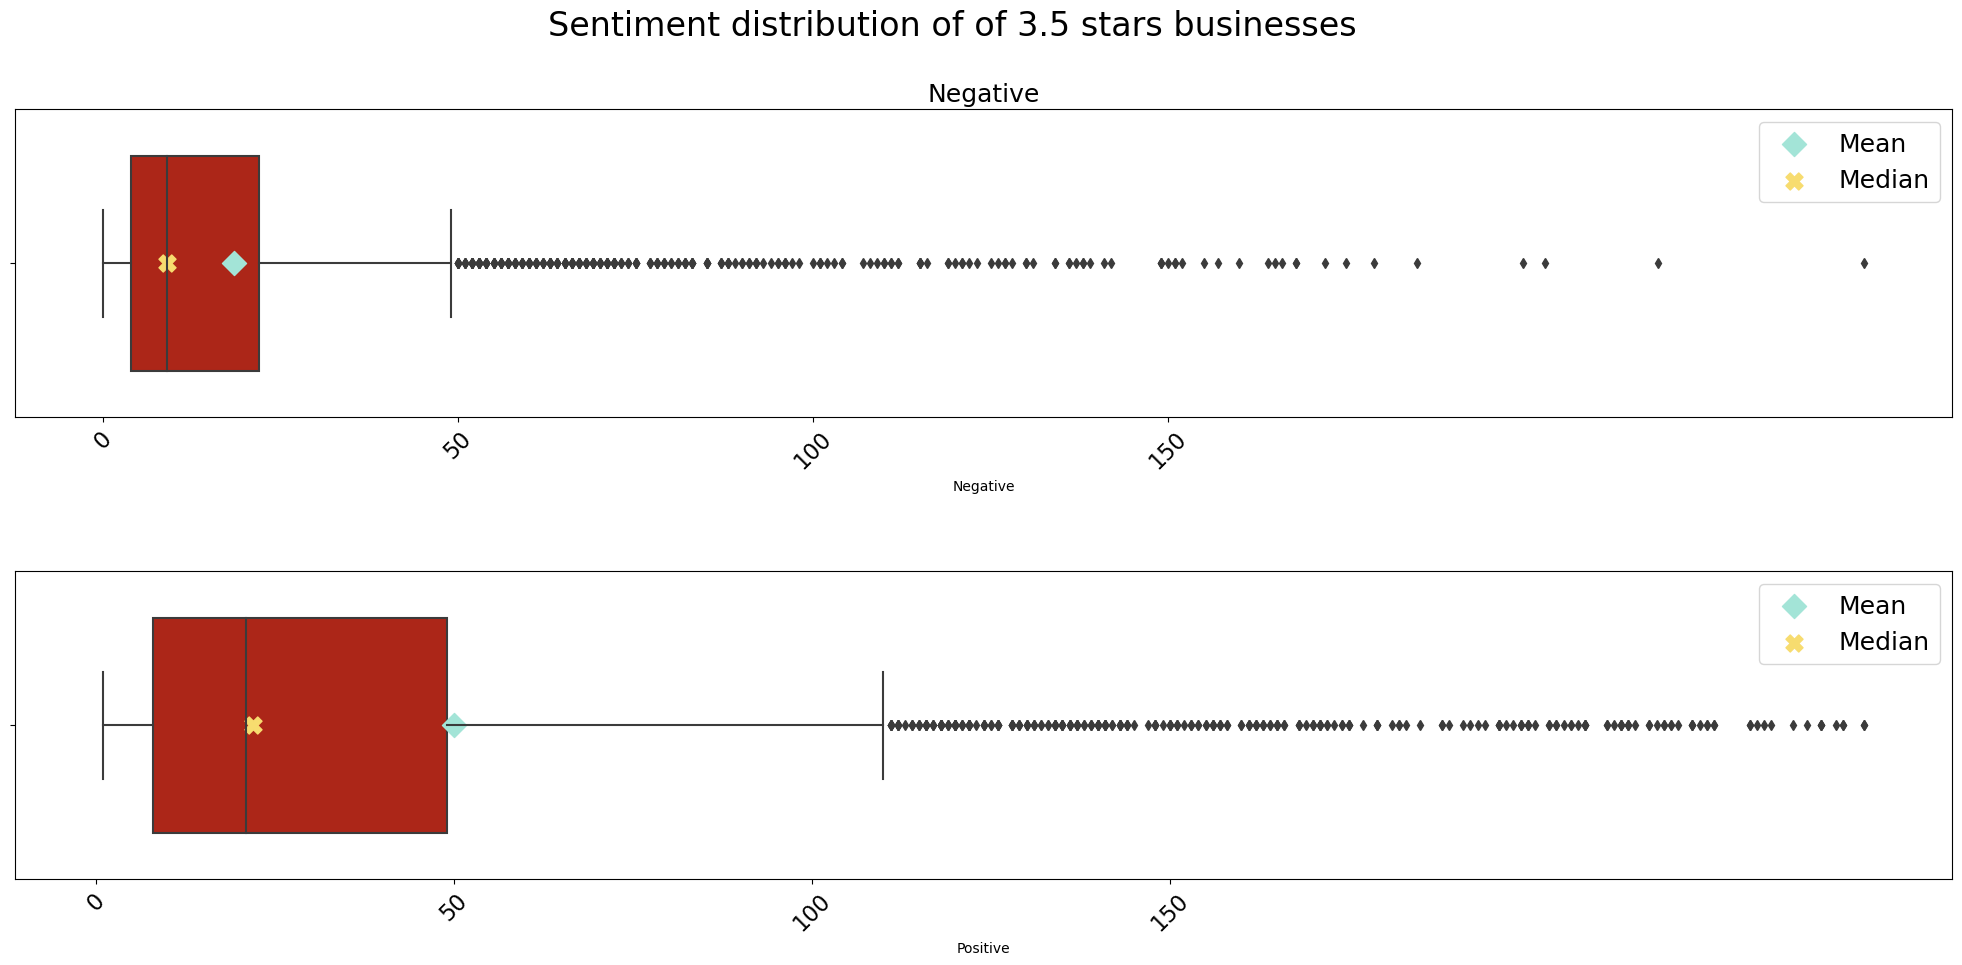

In [11]:
# create a new df to storage sentiment analysis result by each biz
sentiment_counts = sentiment_target.groupby('business_id')['result'].value_counts().unstack(fill_value=0)

# limited the sample group to show in the boxplot, for display reason
sentiment_counts_n = sentiment_counts[sentiment_counts["Negative"] < 250]
sentiment_counts_p = sentiment_counts[sentiment_counts["Positive"] < 250]

plt.figure(figsize=(25, 10))

# set the gap btw 2 plots
plt.subplots_adjust(hspace=0.5)

plt.suptitle('Sentiment distribution of of 3.5 stars businesses', fontsize=24)

# negative subplot
plt.subplot(2, 1, 1)
sns.boxplot(x=sentiment_counts_n['Negative'], color='#c41200', width = 0.7)
# to calculate the mean and medium
means_n = sentiment_counts["Negative"].mean()
medians_n = sentiment_counts["Negative"].median()
# to show the mean and median with different makers in the plot, and defined the size of the makers
plt.scatter(y=[0], x=[means_n], color='#A3E4D7', marker='D', label='Mean', s=150)
plt.scatter(y=[0], x=[medians_n], color='#F7DC6F', marker='X', label='Median', s=150)
# set up the X axis
plt.xticks(np.arange(0, 200, step=50), fontsize = 16, rotation=45)
plt.title('Negative', fontsize = 18)
plt.legend(fontsize = 18)

# positive subplot
plt.subplot(2, 1, 2)
sns.boxplot(x=sentiment_counts_p["Positive"], color='#c41200', width = 0.7)
means_p = sentiment_counts["Positive"].mean()
medians_p = sentiment_counts["Positive"].median()
plt.scatter(y=[0], x=[means_p], color='#A3E4D7', marker='D', label='Mean', s=150)
plt.scatter(y=[0], x=[medians_p], color='#F7DC6F', marker='X', label='Median', s=150)
plt.xticks(np.arange(0, 200, step=50), fontsize = 16, rotation=45)
plt.legend(fontsize = 18)

In [12]:
sentiment_counts.describe()

result     Negative      Neutral     Positive
count   3516.000000  3516.000000  3516.000000
mean      18.460182    11.589022    50.068828
std       27.662287    22.249364    84.957182
min        0.000000     0.000000     1.000000
25%        4.000000     2.000000     9.000000
50%        9.000000     4.000000    22.000000
75%       22.000000    12.000000    54.000000
max      520.000000   438.000000  1785.000000

#### 3.3 Most discussed topic

In [16]:
# Inner join restaurants to review df as review selcted
review_selected = review_all.merge(restaurants[['business_id', 'stars']], how='inner', on='business_id')
# Rename headers to identify specific columns
review_selected.rename(columns={'stars_x': 'review_stars', 'stars_y':'biz_stars'}, inplace=True)
# filter on 3.5 stars restaurants reviews for further analysis
review_selected = review_selected.query('biz_stars == 3.5')
# Print the review selected data
print(f"# Restaurants with 3.5 stars : {review_selected['business_id'].nunique()}, # Reviews : {review_selected['review_id'].nunique()}")
review_selected.head()

# Restaurants with 3.5 stars : 3516, # Reviews : 281695


business_id               review_id  \
425  VHA-b1NH4tIZB_IVEf_pmA  sSQKHpFs8tSXl4Lv34zQgQ   
426  VHA-b1NH4tIZB_IVEf_pmA  I0zFafpznahATV0kqwLktw   
427  VHA-b1NH4tIZB_IVEf_pmA  WmEIgQT7n7S-apOuT2D1Ag   
428  VHA-b1NH4tIZB_IVEf_pmA  oybk1tECjSekgBtaMxL0rg   
429  VHA-b1NH4tIZB_IVEf_pmA  KV_HOy8-Qt3AB4WYsfPvvA   

                                                  text  positive   neutral  \
425  I have to say that Minado is a above the avera...       NaN  0.793211   
426  My family had been coming here for many years ...       NaN       NaN   
427  I know what you are thinking, 5 stars for a su...       NaN  0.706768   
428  Pretty disappointing - this place use to have ...       NaN       NaN   
429  This place is expensive and has soggy food. Th...       NaN       NaN   

     negative                 user_id  review_stars  useful  funny  cool  \
425       NaN  kZOHcAsSBIAoXn7cYbvveA             3       0      0     0   
426  0.978465  kwYkRg8RhYXFc4OnqqWKPw             2       1      0     0   
427       NaN  ztW1RcXsT-bQS5cgeMzgzg             5       8      3     1   
428  0.954907  rjDuYaK41di3_CKioCHXLA             2       1      0     0   
429  0.984502  mbQ-dSss7cu0i68iUzN3fg             1       0      0     0   

           date  biz_stars  
425  2016-11-20        3.5  
426  2017-07-07        3.5  
427  2011-03-13        3.5  
428  2018-03-31        3.5  
429  2019-02-02        3.5

<Axes: title={'center': 'FOOD'}, xlabel='Sentiment score (0 to 1)'>

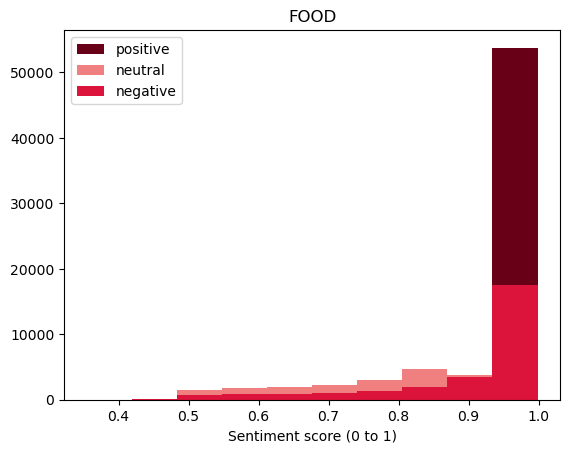

In [18]:
# import cycle and islice to plot custom colors.
from itertools import cycle, islice
# lookup words frequency from the dataframe
word = 'food'
# define color patterns
my_colors = list(islice(cycle(['xkcd:claret', 'lightcoral', 'crimson']), None, len(review_selected)))
# plot sentiment score on stack from 3 different polarity label.
review_selected.loc[review_selected['text'].apply(lambda x: word in x.lower().split()),               
           ['positive', 'neutral','negative']].plot(kind='hist', title=word.upper(), xlabel='Sentiment score (0 to 1)', ylabel="", color=my_colors, bins=10, grid=False) # removing grid